Credit Card Fraud Detection

In [1]:
import pandas as pd

# Read the creditcard.csv file
data = pd.read_csv('creditcard.csv')

# Display the first few rows of the dataset
print(data.head())

# Display basic information about the dataset
print(data.info())



   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:
# Calculate the number of fraudulent transactions
num_fraudulent = data['Class'].sum()

# Calculate the total number of transactions
total_transactions = len(data)

# Calculate the percentage of fraudulent transactions
fraud_percentage = (num_fraudulent / total_transactions) * 100

print(f"Number of fraudulent transactions: {num_fraudulent}")
print(f"Total number of transactions: {total_transactions}")
print(f"Percentage of fraudulent transactions: {fraud_percentage:.4f}%")

Number of fraudulent transactions: 492
Total number of transactions: 284807
Percentage of fraudulent transactions: 0.1727%


Balancing the data

In [2]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Create training and test sets with an 80-20 split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Separate features and target variable
X_train = train_data.drop('Class', axis=1)
y_train = train_data['Class']

# Oversample minority class and undersample majority class
oversampler = RandomOverSampler(random_state=42)
undersampler = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)

# Create a balanced training dataset
balanced_train_data = pd.DataFrame(X_resampled, columns=X_train.columns)
balanced_train_data['Class'] = y_resampled

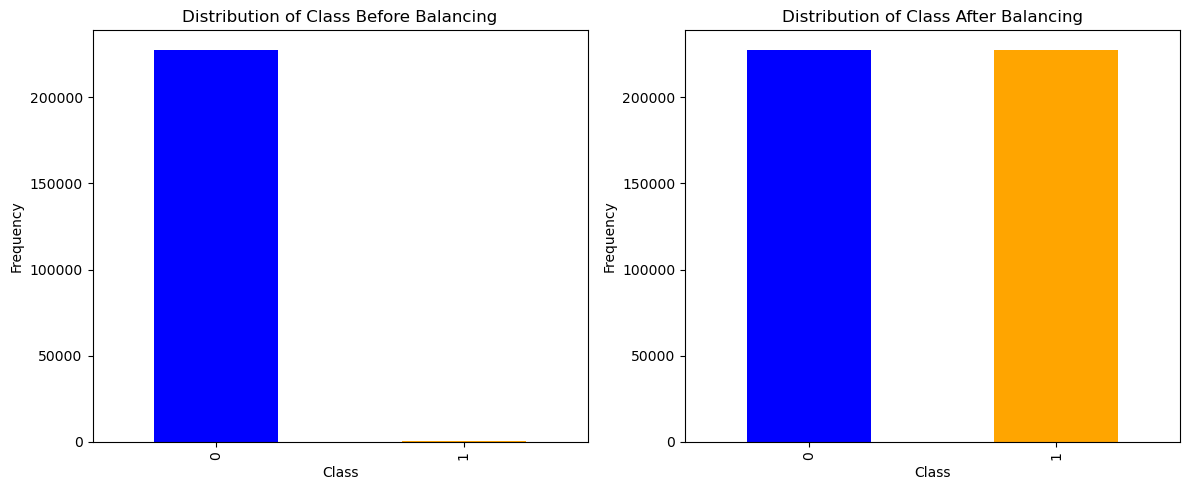

In [3]:

import matplotlib.pyplot as plt

# Plot the distribution of the target variable before balancing
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_data['Class'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Class Before Balancing')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Plot the distribution of the target variable after balancing
plt.subplot(1, 2, 2)
balanced_train_data['Class'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Class After Balancing')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Random Forest Classifier


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score
from scipy.stats import randint

# Define the parameter distribution for hyperparameter tuning
param_dist = {
    'n_estimators': randint(20, 50),
    'max_depth': [None, 5, 10],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Setup Repeated K-Fold cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

# Initialize RandomizedSearchCV with the parameter distribution
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=10, cv=cv, scoring='f1', verbose=1, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV on the balanced training dataset
random_search.fit(balanced_train_data.drop('Class', axis=1), balanced_train_data['Class'])

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

# Predict the target variable "Class" in the test set using the best estimator
y_test_pred = random_search.best_estimator_.predict(test_data.drop('Class', axis=1))




Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 45}
Best cross-validation score: 1.00



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.79      0.88        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.94     56962
weighted avg       1.00      1.00      1.00     56962


Test accuracy: 0.9996
Test F1 score: 0.8750


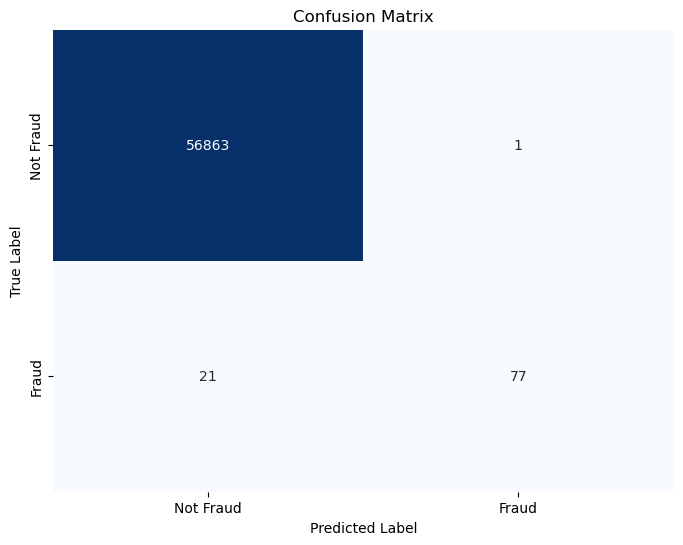

In [9]:
# Evaluate the model on the test set
print("\nClassification Report:")
print(classification_report(test_data['Class'], y_test_pred))

# Print test accuracy
print(f"\nTest accuracy: {accuracy_score(test_data['Class'], y_test_pred):.4f}")

# Print test F1 score
print(f"Test F1 score: {f1_score(test_data['Class'], y_test_pred):.4f}")

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the confusion matrix
conf_matrix = confusion_matrix(test_data['Class'], y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

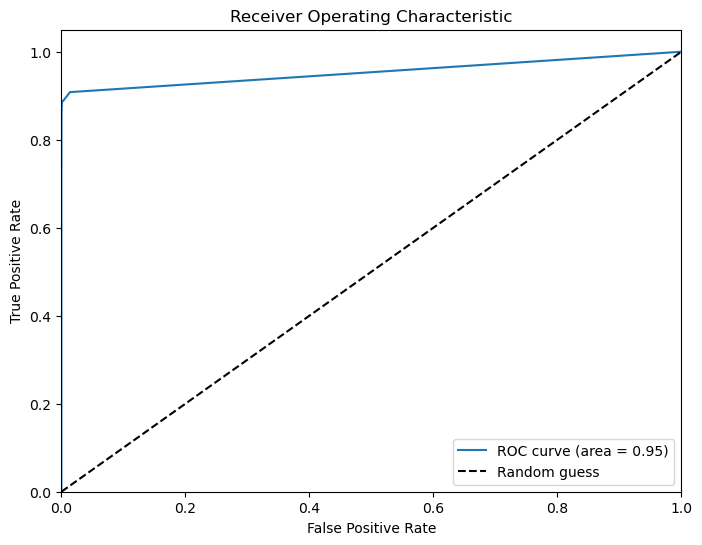

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_data['Class'], random_search.best_estimator_.predict_proba(test_data.drop('Class', axis=1))[:, 1])

# Calculate the AUC
auc_score = roc_auc_score(test_data['Class'], random_search.best_estimator_.predict_proba(test_data.drop('Class', axis=1))[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Hyperparameter combinations and their mean test scores:
                                              params  mean_test_score
0  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...         0.996081
1  {'max_depth': None, 'min_samples_leaf': 1, 'mi...         0.999954
2  {'max_depth': 10, 'min_samples_leaf': 3, 'min_...         0.996625
3  {'max_depth': None, 'min_samples_leaf': 3, 'mi...         0.999925
4  {'max_depth': 5, 'min_samples_leaf': 2, 'min_s...         0.958562
5  {'max_depth': None, 'min_samples_leaf': 1, 'mi...         0.999954
6  {'max_depth': 5, 'min_samples_leaf': 1, 'min_s...         0.961076
7  {'max_depth': None, 'min_samples_leaf': 3, 'mi...         0.999925
8  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...         0.996578
9  {'max_depth': 5, 'min_samples_leaf': 3, 'min_s...         0.961357


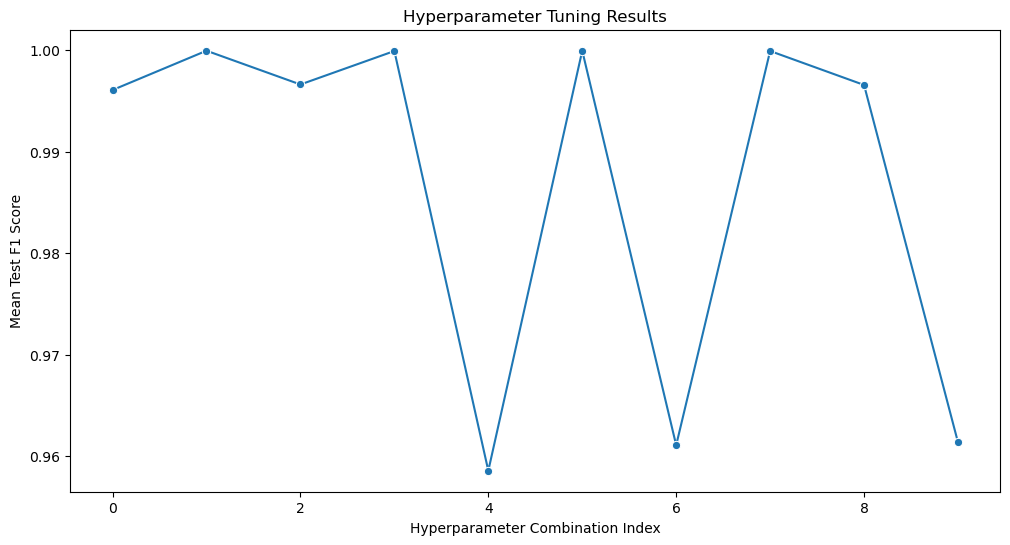

Best hyperparameter combination index: 1
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 45}


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the results to a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

# Display all hyperparameter combinations and their mean test scores
print("Hyperparameter combinations and their mean test scores:")
print(results_df[['params', 'mean_test_score']])

# Plot the mean test score for each hyperparameter combination
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x=results_df.index, y='mean_test_score', marker='o')
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Test F1 Score')
plt.show()

# Highlight the best hyperparameter combination
best_index = results_df['rank_test_score'].idxmin()
print(f"Best hyperparameter combination index: {best_index}")
print(f"Best hyperparameters: {results_df.loc[best_index, 'params']}")

Isolation Forest

Fitting 10 folds for each of 20 candidates, totalling 200 fits


c:\Users\dasra\.conda\envs\datascience\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.33      0.35      0.34        98

    accuracy                           1.00     56962
   macro avg       0.66      0.67      0.67     56962
weighted avg       1.00      1.00      1.00     56962


Test accuracy: 0.9977
Test Fbeta score: 0.3383


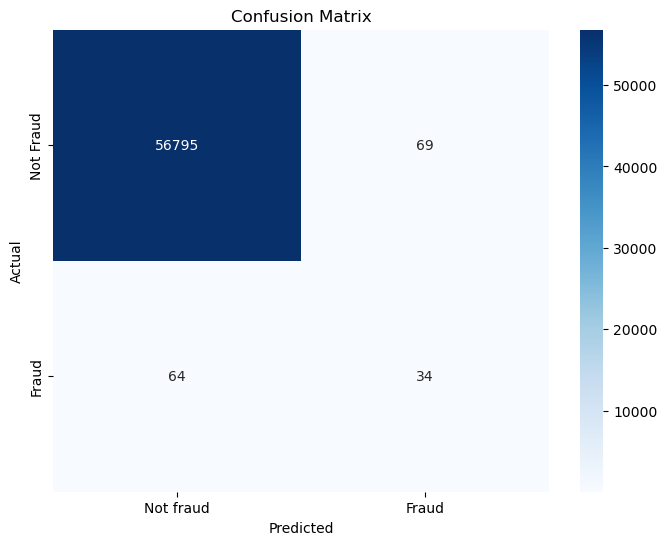

In [47]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


X_test = test_data.drop('Class', axis=1)
y_test = test_data['Class']

# Initialize the Isolation Forest model
iso_forest = IsolationForest(random_state=42)

# Define a parameter distribution for RandomizedSearchCV
param_dist_iso = {
    'n_estimators': [50, 150],
    'max_samples': [0.6, 0.8, 1.0],
    'contamination': [0.0017, 0.0020, 0.0023],
    'max_features': [0.5, 0.75, 1.0]
}
# Setup Repeated K-Fold cross-validation
cv_iso = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# Create a custom scorer for F2 Score
fbeta_scorer = make_scorer(fbeta_score, beta=1, average='binary')


# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=iso_forest,
    param_distributions=param_dist_iso,
    n_iter=20,  # Number of parameter settings sampled
    cv=cv_iso,  # Cross-validation folds
    scoring=fbeta_scorer,  # Use ROC AUC for evaluation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model using the unbalanced training data
random_search.fit(X_train, y_train)

# Predict the target variable using the test data
y_pred = random_search.best_estimator_.predict(X_test)

# Convert predictions to binary (1 for anomaly, 0 for normal)
y_pred_binary = [1 if x == -1 else 0 for x in y_pred]

# Evaluate the model on the test set
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Print test accuracy
print(f"\nTest accuracy: {accuracy_score(y_test, y_pred_binary):.4f}")



# Calculate and print test F2 score
print(f"Test Fbeta score: {fbeta_score(y_test, y_pred_binary, beta=1):.4f}")


# Compute confusion matrix
conf_matrix_iso = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_iso, annot=True, fmt='d', cmap='Blues', xticklabels=['Not fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



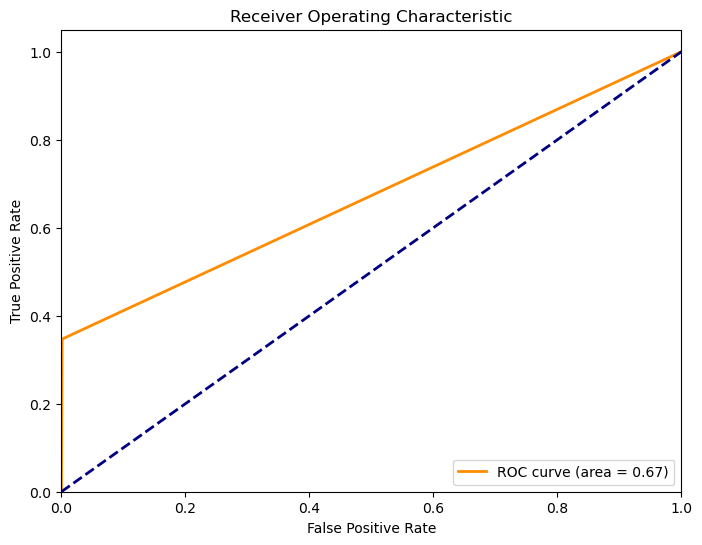

In [48]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_binary)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Logistic Regression

Fitting 10 folds for each of 50 candidates, totalling 500 fits


c:\Users\dasra\.conda\envs\datascience\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.03      0.65      0.06        98

    accuracy                           0.96     56962
   macro avg       0.51      0.81      0.52     56962
weighted avg       1.00      0.96      0.98     56962


Test accuracy: 0.9632


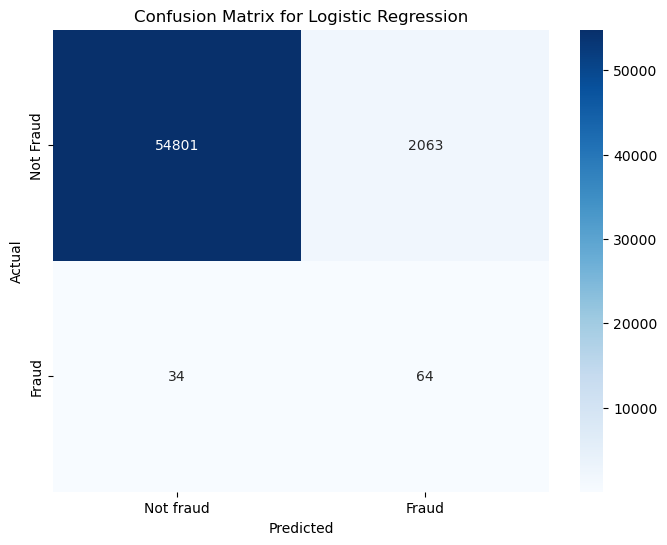

In [53]:
from sklearn.linear_model import LogisticRegression
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(solver='saga', random_state=42)

# Define a parameter distribution for RandomizedSearchCV
from scipy.stats import uniform

param_dist_logistic = {
    'C': uniform(loc=0.001, scale=100),  # Random float between 0.001 and 100
    'penalty': ['elasticnet'],  
    'l1_ratio': uniform(loc=0.0, scale=1.0),  # Random float between 0.1 and 0.9
    'max_iter': [100, 200, 300]  # Still discrete
}
# Setup Repeated K-Fold cross-validation
cv_logistic = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# Set up RandomizedSearchCV
random_search_logistic = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_dist_logistic,
    n_iter=50,  # Number of parameter settings sampled
    cv=cv_logistic,  # Cross-validation folds
    scoring='f1',  # Use F1 Score for evaluation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model using the balanced training data
random_search_logistic.fit(balanced_train_data.drop('Class', axis=1), balanced_train_data['Class'])

# Predict the target variable using the test data
y_pred_logistic = random_search_logistic.best_estimator_.predict(X_test)

# Evaluate the model on the test set
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))

# Print test accuracy
print(f"\nTest accuracy: {accuracy_score(y_test, y_pred_logistic):.4f}")

# Compute confusion matrix
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=['Not fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

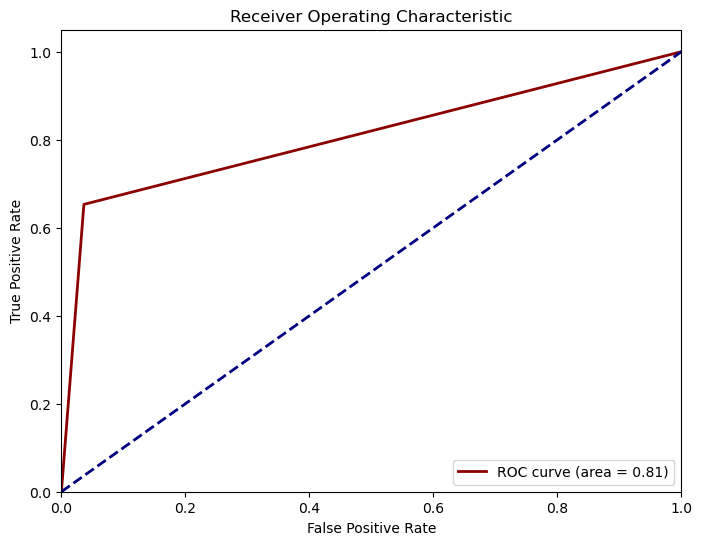

In [54]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_logistic)
roc_auc = roc_auc_score(y_test, y_pred_logistic)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()